In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [2]:
from os import environ
environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import keras

from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

Using plaidml.keras.backend backend.


## Load and resize the images

In [3]:
IMAGE_LIB = '../../vascus/synimages/'
MASK_LIB = '../../vascus/synmasks/'
IMG_HEIGHT, IMG_WIDTH = 64, 64
SEED=42

In [4]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.png']

x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED).astype("uint8")
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    #some normalization so values should be between 0-1
    diff = np.max(im) - np.min(im)
    #print(name + str(diff))
    if(diff!=0):
        x_data[i] = (im - np.min(im)) / diff
    else:
        x_data[i]=im/255.

y_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(MASK_LIB + name, cv2.IMREAD_UNCHANGED).astype('uint8')
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    y_data[i] = im/255.

In [5]:
x_data.shape

(328, 64, 64)

In [6]:
from sklearn.utils import shuffle

x_data, y_data = shuffle(x_data, y_data)

In [7]:
x_data.shape

(328, 64, 64)

In [8]:
x_data = x_data[:,:,:,np.newaxis]
y_data = y_data[:,:,:,np.newaxis]
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.01)

In [9]:
x_train.shape

(324, 64, 64, 1)

In [10]:
x_val.shape

(4, 64, 64, 1)

## Define and train model

In [11]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [139]:
#for 32 input

input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

In [12]:
#for 64 input

input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=4, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


In [202]:
#for 128 input

input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=64, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=48, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=128, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

In [203]:
#for 256 input

input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=128, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=96, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=256, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 4)    40          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 4)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 8)    296         max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [14]:
#seed is VERY important for image and mask transform simultaneously

def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            horizontal_flip=True,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=123)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            horizontal_flip=True,
            zoom_range=0.1
            ).flow(y_train, y_train, batch_size, seed=123)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

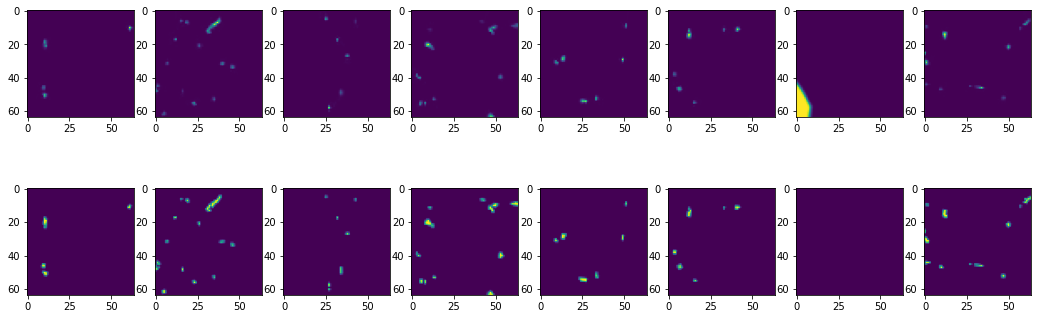

In [15]:

image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(2,8, figsize=(18,6))
for i in range(8):
    ax[0,i].imshow(image_batch[i,:,:,0])
    ax[1,i].imshow(mask_batch[i,:,:,0])
plt.show()

In [16]:
model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])

In [17]:
weight_saver = ModelCheckpoint('../../models/save_syn64_best.h5', monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint("../../models/save_syn64_{epoch}.h5"),
]

In [19]:
hist = model.fit_generator(my_generator(x_train, y_train, 8),
                           steps_per_epoch = 40,
                           validation_data = (x_val, y_val),
                           epochs=200, 
                           #callbacks = [weight_saver])
                           #callbacks = [weight_saver, annealer])
                           callbacks = callbacks)

Epoch 1/200


INFO:plaidml:Analyzing Ops: 439 of 446 operations complete


40/40 [==============================] - 24s 603ms/step - loss: 0.6580 - dice_coef: 0.0216 - val_loss: 0.5893 - val_dice_coef: 0.0374
Epoch 2/200
40/40 [==============================] - 18s 448ms/step - loss: 0.3923 - dice_coef: 0.0150 - val_loss: 0.2462 - val_dice_coef: 0.0042
Epoch 3/200
40/40 [==============================] - 1s 31ms/step - loss: 0.1366 - dice_coef: 0.0035 - val_loss: 0.2773 - val_dice_coef: 0.0017
Epoch 4/200
40/40 [==============================] - 1s 31ms/step - loss: 0.1203 - dice_coef: 0.0040 - val_loss: 0.2310 - val_dice_coef: 0.0023
Epoch 5/200
40/40 [==============================] - 1s 31ms/step - loss: 0.1048 - dice_coef: 0.0052 - val_loss: 0.2021 - val_dice_coef: 0.0028
Epoch 6/200
40/40 [==============================] - 1s 31ms/step - loss: 0.0927 - dice_coef: 0.0053 - val_loss: 0.1767 - val_dice_coef: 0.0033
Epoch 7/200
40/40 [==============================] - 1s 31ms/step - loss: 0.0824 - dice_coef: 0.0074 - val_loss: 0.1448 - val_dice_coef: 0.0071


40/40 [==============================] - 1s 30ms/step - loss: 0.0171 - dice_coef: 0.5555 - val_loss: 0.0168 - val_dice_coef: 0.7237
Epoch 114/200
40/40 [==============================] - 1s 30ms/step - loss: 0.0170 - dice_coef: 0.5551 - val_loss: 0.0164 - val_dice_coef: 0.7276
Epoch 115/200
40/40 [==============================] - 1s 30ms/step - loss: 0.0167 - dice_coef: 0.5498 - val_loss: 0.0166 - val_dice_coef: 0.7286
Epoch 116/200
40/40 [==============================] - 1s 30ms/step - loss: 0.0168 - dice_coef: 0.5467 - val_loss: 0.0169 - val_dice_coef: 0.7206
Epoch 117/200
40/40 [==============================] - 1s 30ms/step - loss: 0.0168 - dice_coef: 0.5640 - val_loss: 0.0178 - val_dice_coef: 0.7114
Epoch 118/200
40/40 [==============================] - 1s 30ms/step - loss: 0.0171 - dice_coef: 0.5561 - val_loss: 0.0154 - val_dice_coef: 0.7408
Epoch 119/200
40/40 [==============================] - 1s 31ms/step - loss: 0.0168 - dice_coef: 0.5612 - val_loss: 0.0161 - val_dice_coef:

## Evaluate

In [125]:
#model.load_weights('../../models/save_lung_256_300k_50.h5')
model.load_weights('../../models/save_syn64_best.h5')

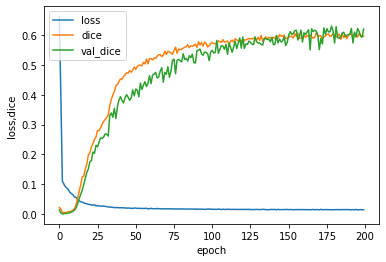

In [149]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['dice_coef'])
plt.plot(hist.history['val_dice_coef'])
plt.title('')
plt.ylabel('loss,dice')
plt.xlabel('epoch')
plt.legend(['loss', 'dice','val_dice'], loc='upper left')
plt.show()

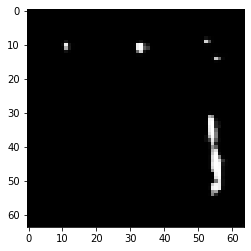

In [22]:
plt.imshow(model.predict(x_train[10].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

In [296]:
y_hat = model.predict(x_val)

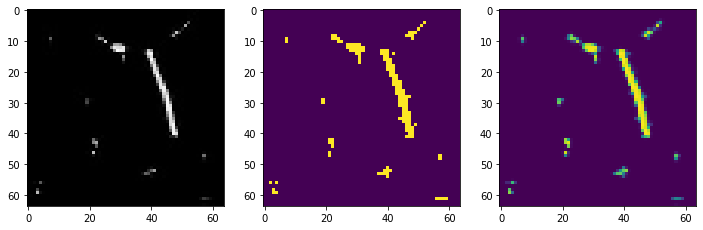

In [300]:
N=65
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_val[N,:,:,0], cmap='gray')
ax[1].imshow(y_val[N,:,:,0])
ax[2].imshow(y_hat[N,:,:,0])

============== TESTING ON UNKNOWN SET =================

In [236]:
IMAGE_LIB = '../../vascus/synimages_test/'
MASK_LIB = '../../vascus/synmasks_test/'
IMG_HEIGHT, IMG_WIDTH = 64, 64
SEED=42

In [237]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.png']

x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    #some normalization so values should be between 0-1
    diff = np.max(im) - np.min(im)
    if(diff!=0):
        im = (im - np.min(im)) / diff
    else:
        im=im/255.
    x_data[i] = im

y_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(MASK_LIB + name, cv2.IMREAD_UNCHANGED).astype('float32')/255.
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    y_data[i] = im

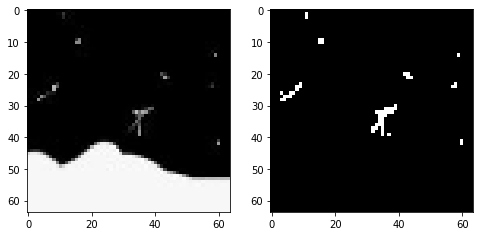

In [238]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(x_data[15], cmap='gray')
ax[1].imshow(y_data[15], cmap='gray')
plt.show()

In [239]:
x_test = x_data[:,:,:,np.newaxis]
y_test = y_data[:,:,:,np.newaxis]


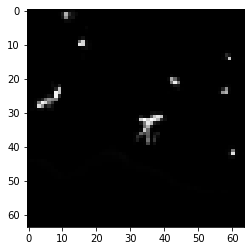

In [240]:
plt.imshow(model.predict(x_test[15].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

NOW LETS SEE IF IT WORKS ON REAL DATA

In [182]:
IMAGE_LIB = '../../lungs_ds6/norma_test/'
SRCIMG_HEIGHT, SRCIMG_WIDTH = 256, 256

In [183]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.jpg']

x_data = np.empty((len(all_images), SRCIMG_HEIGHT, SRCIMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED).astype("uint8")
    im = cv2.resize(im, dsize=(SRCIMG_HEIGHT, SRCIMG_WIDTH), interpolation=cv2.INTER_LANCZOS4)
    #some normalization so values should be between 0-1
    diff = np.max(im) - np.min(im)
    #print(diff)
    if(diff>1):
        if(diff!=0):
            im = (im - np.min(im)) / diff
        else:
            im=im/255.
            
    x_data[i] = im


In [184]:
x_data.shape

(415, 256, 256)

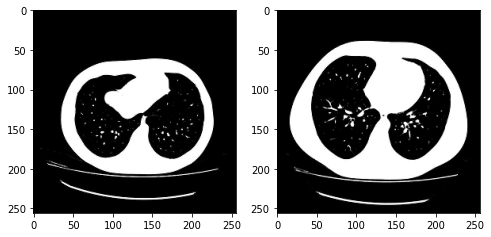

In [185]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(x_data[150], cmap='gray')
ax[1].imshow(x_data[151], cmap='gray')
plt.show()

In [186]:
#now lets make patches
from patchify import patchify, unpatchify

realimg = x_data[151]

patches = patchify(realimg, (64,64), step=64) # split image into 2*3 small 2*2 patches.

patches.shape


(4, 4, 64, 64)

In [187]:
im = patches[2,3,]

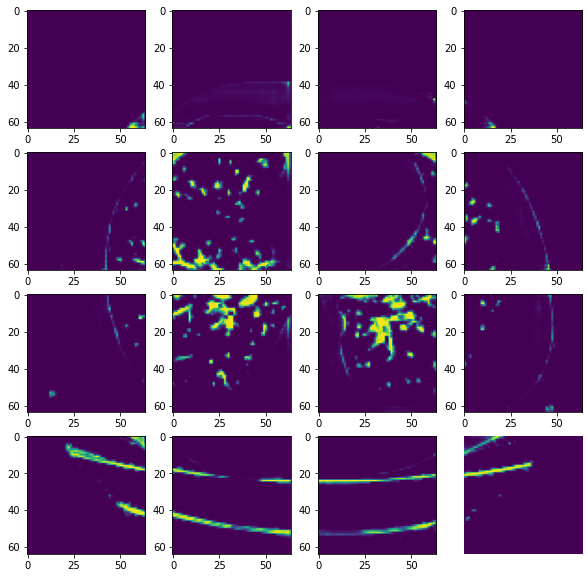

In [188]:
fix, ax = plt.subplots(4,4, figsize=(10,10))
plt.axis('off')
#fix.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
for i in range(4):
    for j in range(4):
        im = patches[i,j,]  
        pred = model.predict(im.reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))
        ax[i,j].imshow(pred[0,:,:,0])

plt.show()



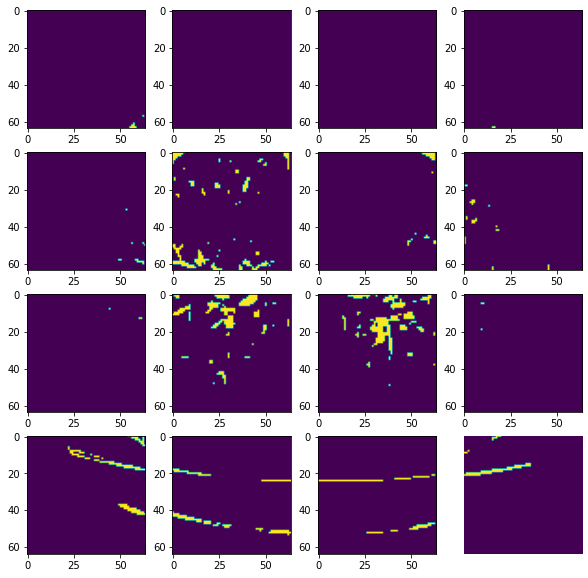

In [189]:
fix, ax = plt.subplots(4,4, figsize=(10,10))
plt.axis('off')
#fix.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
for i in range(4):
    for j in range(4):
        im = patches[i,j,]  
        pred = model.predict(im.reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))
        ret,thresh1 = cv2.threshold(pred[0,:,:,0],0.7,1.0,cv2.THRESH_BINARY)
        patches[i,j,] = thresh1
        ax[i,j].imshow(thresh1)

plt.show()


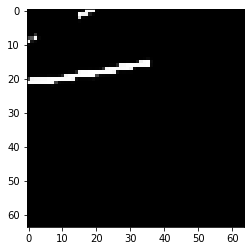

In [31]:
plt.imshow(model.predict(im.reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

In [32]:
the_mask = unpatchify(patches, realimg.shape)
the_mask.shape


(256, 256)

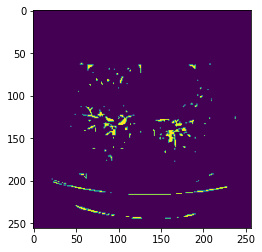

In [33]:
plt.imshow(the_mask)

=================== NOW Lets make a 3D-work ===================


In [209]:
import imageio

In [210]:
IMAGE_LIB = '../../P012/slices/'
MASK_LIB = '../../P012/vesselmasks/'
SRCIMG_HEIGHT, SRCIMG_WIDTH = 256, 256

In [211]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.png']

x_data = np.empty((len(all_images), SRCIMG_HEIGHT, SRCIMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED)
    im = cv2.resize(im, dsize=(SRCIMG_HEIGHT, SRCIMG_WIDTH), interpolation=cv2.INTER_LANCZOS4)
    alpha=3.3
    beta=-280
    im=cv2.addWeighted(im,alpha,np.zeros(im.shape, im.dtype),0,beta)
    #some normalization so values should be between 0-1
    diff = np.max(im) - np.min(im)
    if(diff!=0):
        im = (im - np.min(im)) / diff
    else:
        im=im/255.
            
    x_data[i] = im


In [212]:
x_data.shape

(363, 256, 256)

In [215]:
IMG_HEIGHT = 64
IMG_WIDTH = 64

def procesImage(realimg):
    #plt.imshow(realimg)
    patches = patchify(realimg, (IMG_HEIGHT,IMG_WIDTH), step=IMG_WIDTH)
    
    for i in range(4):
        for j in range(4):
            im = patches[i,j,] 
            pred = model.predict(im.reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))
            ret,thresh1 = cv2.threshold(pred[0,:,:,0],0.7,1.0,cv2.THRESH_BINARY)
            patches[i,j,] = thresh1
    
    return unpatchify(patches, realimg.shape)
    

In [216]:
masks = np.empty((x_data.shape[0], SRCIMG_HEIGHT, SRCIMG_WIDTH), dtype='float32')
N=170
#plt.imshow(x_data[N], cmap='gray')

i=-1
for img in x_data:
    i+=1
    #print(str(realimg.shape))
    if(i!=N):
        continue
    #plt.imshow(img)
    themask = procesImage(img)
    #plt.imshow(themask)
    masks[i]=themask
    if(i>99):
        fname = ""+str(i);
    elif(i>10):
        fname = "0"+str(i);
    else:
        fname = "00"+str(i);
    #print(str(np.max(themask)))
    #plt.imshow(themask)
    #imageio.imwrite(MASK_LIB+"P012_"+fname+".png", themask)
    
print("Images saved: "+ str(i))



AttributeError: 'numpy.ndarray' object has no attribute 'header'

In [219]:
import nibabel as nib

affine = masks.eye(3)
nifti_file = nib.Nifti1Image(masks,affine)

nib.save(nifti_file, MASK_LIB +"P012.nii")

AttributeError: 'numpy.ndarray' object has no attribute 'eye'

================== ROC-AUC??? =================

In [246]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [235]:
y_data.shape

(31, 64, 64)

In [231]:
x_test.shape

(31, 64, 64, 1)

In [232]:
y_pred = model.predict(x_test)

In [233]:
y_true = []
y_prd = []

for img in y_data:
#  pred = model(img)  # get prediction for each pixel in the image
    y_true.append(img.flatten())  # flatten all targets
#  y_pred.append(pred.to_numpy().flatten())  # flatten all predictions
for img in y_pred:
#  pred = model(img)  # get prediction for each pixel in the image
    y_prd.append(img.flatten())  # flatten all targets
#  y_pred.append(pred.to_numpy().flatten())  # flatten all predictions

In [243]:
# concatenate all predictions and targets:
y_true = np.concatenate(y_true, axis=0)
y_prd = np.concatenate(y_prd, axis=0)
# copte the ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prd)


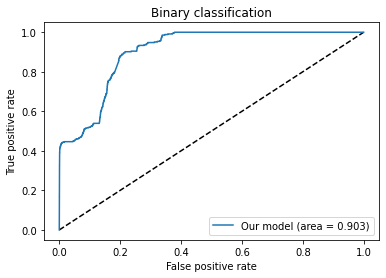

In [247]:
aucf = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Our model (area = {:.3f})'.format(aucf))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Binary classification')
plt.legend(loc='best')
plt.show()